# Flexibility in a Search Model 

## Model

- homogeneous workers with utility $u(w, k) = w + \gamma k$ if employed and flow (dis)utility $b$ if unemployed
- heterogeneous firms endowed with flexibility level $k \in \{0,1,..., K\}$ with probability $p_k$ and costing $c(k)=ck$ with production function $y(x,k) = \zeta^k x$ and linear profit $\pi(x,k) = y(x,k)-w(x,k)-c(k)$
- search parameters: discount rate $\rho$, unemployed meet firms at rate $\lambda$ (no on-the-job search), upon meeting draw match-specific productivity $x \sim G(x)$, bargaining parameter $\alpha$, employed face separation shock $\eta$

## Necessary Packages

In [ ]:
# General
import numpy as np
import pandas as pd 
import scipy.stats as stats

# Graphics
import matplotlib.pyplot as plt 
import seaborn as sns

# Estimation
from scipy.optimize import minimize

# Debugging
import pdb


## Data 
- Homogeneity measures: aged 25-55; white; either college graduate (col_edu==1) or HS graduate (hs_edu==1)
- employed workers earn wage $w$ (in 2018 dollars) at firm with flexibility level $k$
    - flexibility measures:
        - Schedule Flexibility 
            - 0: No flexibility in start and end times of work 
            - 1: Able to change start and end times of work 
        - Location Flexibility 
            - 0: Not able to work from home
            - 1: Able to work from home
- unemployed workers have unemployment durations of $t$


In [ ]:
df=pd.read_stata('workfile.dta', columns=['hs_edu', 'col_edu', 'sex','employed', 'flexsched', 'flex_sched_score', 'flexloc', 'flex_loc_score', 'hrwage_r', 'dur'])

df=df[df['col_edu']==1] # change based on which to estimate - label Figures, Output to CSV to match


In [ ]:
def winsorize(data: pd.DataFrame, flex:str, n_flex:int, winsorized_wage:str, raw_wage:str, employed:str, percentile: float):
    nth_pctl = np.zeros(1)

    for k in range(2):
        tmp = data[data[flex]==k]
        nth = np.percentile(tmp[raw_wage],1)
        nth_pctl = np.append(nth_pctl, nth)

    data[winsorized_wage]=data[raw_wage]

    for k in range(2):
        data[winsorized_wage].iloc[(data[raw_wage]<nth_pctl[k+1]) & (data[flex]==k)]=nth_pctl[k+1] #k+1 because empty array initiates with zero

    return data[[winsorized_wage, raw_wage]].groupby([data[employed],data[flex]]).describe()

### Men

In [ ]:
men = df[df['sex']=='male']
len(men)

In [ ]:
winsorize(men, 'flexsched', 2, 'wage_flexsched', 'hrwage_r', 'employed', 1)

In [ ]:
winsorize(men, 'flexloc', 2, 'wage_flexloc', 'hrwage_r', 'employed', 1)

### Women

In [ ]:
women = df[df['sex']=='female']
len(women)

In [ ]:
winsorize(women, 'flexsched', 2, 'wage_flexsched', 'hrwage_r', 'employed', 1)

In [ ]:
winsorize(women, 'flexloc', 2, 'wage_flexloc', 'hrwage_r', 'employed', 1)

## Model Independent Functions

In [ ]:
def lognormpdf(x: np.array, μ: float, σ: float):
    """
    Calculates lognormal pdf without stats packages
    """
    
    denom = x * σ * np.sqrt(2*np.pi)
    exp_num = -(np.log(x)-μ)**2
    exp_denom = 2 * σ * σ
    num = np.exp(exp_num/exp_denom)
    
    return num/denom

In [ ]:
def lognormsf(x: np.array, μ: float, σ: float):
    """
    Calculates lognormal cdf with scipy.stats normal cdf
    """
    
    lnx = np.log(x)
    num = lnx - μ
    denom = σ
    
    return 1-stats.norm.cdf(num/denom)

In [ ]:
def bootstrap(data: pd.DataFrame, n_samples:int):
    """
    Thanks, Caleb
    """
    bootstrapped_sample_list = []
    
    for n in range(n_samples):
        nth_sample = data.sample(frac=1, replace=True)
        bootstrapped_sample_list.append(nth_sample)
    
    return bootstrapped_sample_list

In [ ]:
def std_error(values):
    """
    Calculates the standard error (standard deviation of values divided by square root of the number of values) of some values 
    """
    
    stderr = np.std(values) / np.sqrt(len(values))

    return stderr

In [ ]:
def fit_stats(values):
    """
    Returns mean and standard error from a list of values 
    
    Functions:
    - std_error(values)
    """
    
    mean = np.mean(values)
    
    stderr = std_error(values)
    
    return [mean, stderr]
#     return print("Boostrapped value ", str(mean), "\nStandard error    ", str(stderr),"\n")

## Model Functions

In [ ]:
def Pr_wage_given_match(data: pd.DataFrame, flex: str, wage: str, res_wage: np.array, α: float, γ: float, ζ: float, c_k: np.array, μ: float, σ: float):
    """
    Calculates probability of a wage draw conditional on a match being formed 
    
    Inputs
    - data: DataFrame
    - flex: string for name of flexibility column
    - wage: string for name of wage column
    - res_wage: array of observed minimum wage of flexibility k
    - α: bargaining parameter    
    - γ: utility weight of flexibility k
    - ζ: productivity weight of flexibility k
    - c_k: Kx1 array of cost of providing flexibility
    - μ: location parameter of the log-normal wage distribution
    - σ: scale parameter of the log-normal wage distribution
    
    Functions
    - lognormpdf(x: np.array, μ: float, σ: float)
    - lognormsf(x: np.array, μ: float, σ: float)
    """
    employed_indiv = np.zeros(1) #sets first entry to zero 

    for k in range(len(c_k)):
        tmp = data[data[flex]==k]
        
        g = ( 1/( α*(ζ**k) ) ) * lognormpdf( ( ( tmp[wage] - (1-α)*(res_wage[k]) + α*c_k[k] )/( α*(ζ**k) ) ), μ, σ )
        
        G_tilde = lognormsf( ( res_wage[k] + c_k[k] )/(ζ**k) , μ, σ )
        
        divide_thing = g/G_tilde
        employed_indiv = np.append(employed_indiv, divide_thing)
    
    return employed_indiv[1:] #removes first entry 


In [ ]:
def hazard(res_wage: np.array, p_k: np.array, λ: float, γ: float, ζ: float, c_k: np.array, μ: float, σ: float):
    """
    Calculates the hazard rate out of unemployment 
    
    Inputs
    - res_wage: array of observed minimum wage of flexibility k
    - p_k: Kx1 array of probability of each level of flexibility
    - λ: arrival rate of offer
    - ζ: productivity weight of flexibility k
    - γ: utility weight of flexibility k    
    - c_k: Kx1 array of cost of providing flexibility    
    - μ: location parameter of the log-normal wage distribution
    - σ: scale parameter of the log-normal wage distribution
    
    Functions
    - lognormsf(x: np.array, μ: float, σ: float)
    """
    
    prob_sum = 0
    
    if len(p_k)!=len(c_k):
        return print("Length of p_k and c_k do not match.")
    else:
        for k in range(len(c_k)):
            prob_sum += p_k[k] * lognormsf( ( res_wage[k] + c_k[k] )/(ζ**k) , μ, σ )

    return λ*prob_sum

In [ ]:
def log_L(data: pd.DataFrame, flex: str, wage: str, dur: str, α: float, λ: float, η: float, γ: float, ζ: float, c_k: np.array, μ: float, σ: float):
    """
    Calculates the log-likelihood for the model
    
    Inputs
    - data: DataFrame
    - flex: string for column of flexibility index (k)
    - wage: string for column of wage data 
    - dur: string for unemployment duration data
    - α: bargaining parameter
    - λ: arrival rate of offer
    - η: termination rate
    - γ: utility weight of flexibility k   
    - ζ: productivity weight of flexibility k    
    - c_k: Kx1 array of cost of providing flexibility
    - μ: location parameter of the log-normal wage distribution
    - σ: scale parameter of the log-normal wage distribution
    
    Functions
    - hazard(res_wage: np.array, p_k: np.array, λ: float, γ: float, ζ: float, c_k: np.array, μ: float, σ: float)
    - Pr_wage_given_match(data: pd.DataFrame, flex: str, wage: str, res_wage: np.array, α: float, γ: float, ζ: float, c_k: np.array, μ: float, σ: float)
    """
    p_k = data[flex].value_counts(normalize=True).sort_index().array
    res_wage = data[wage].groupby(data[flex]).min().array - γ*(np.arange(0, len(p_k)))
        
    N_log_h = data.count() * np.log( hazard(res_wage, p_k, λ, γ, ζ, c_k, μ, σ) )
    N_log_h_plus_η = data.count() * np.log( hazard(res_wage, p_k, λ, γ, ζ, c_k, μ, σ) + η )
    
    empl_data = np.sum( np.log( Pr_wage_given_match(data, flex, wage, res_wage, α, γ, ζ, c_k, μ, σ) ) )
    
    Nu_log_η = data[dur].count() * np.log(η)
    
    unempl_data = hazard(res_wage, p_k, λ, γ, ζ, c_k, μ, σ) * np.sum(data[dur])
    
    logL = -(N_log_h - N_log_h_plus_η + empl_data + Nu_log_η - unempl_data)
    
    return logL[0]

## Estimation

- One issue: three variables for flexibility (cost $c$, productivity $\zeta$, and utility $\gamma$)
    - Set two out of three using literature values <- CURRENT SOLUTION
    - Create iterative process where 2 out of 3 set by lit, find 3rd, use in next estimation to find other? 
        - Potentially issues in ordering? Fixed point argument? 
    - Remove cost $c$ by argument that TFP will account for the relative inputs and outputs ? (see notes on Bloom et al 2015)
    - 2-stage estimation? 
- Using Nelder-Mead, there is not a Hessian to calculate standard errors, so use bootstrap method 
    - Other idea: check log likelihood when only having one value to identify at a time

In [ ]:
def est_gamma(data: pd.DataFrame, flex: str, wage: str, duration: str):
    """
    Estimate parameter values for λ, η, γ, μ, σ
    
    Inputs
    - data: DataFrame
    - flex: string for column of flexibility index (k)
    - wage: string for column of wage data 
    - duration: string for unemployment duration data
    
    Functions
    - log_L(data, flex, wage, dur, α, λ, η, γ, ζ, c_k, μ, σ)
    """
    
    params = np.array([λ, η, γ, data[wage].mean(), data[wage].std()])
    
    Bounds = ((0,99), (0,99), (-99,99), (0,99), (0,99))
    
    logL_opt = lambda x: log_L(data, flex, wage, duration, 
                                α, x[0], x[1], x[2], ζ, c_k, 
                                x[3], x[4])

    est = minimize(logL_opt, params, method='Nelder-Mead', options={'maxiter':1000}, bounds=Bounds)
    
    return [est.fun, est.x]

In [ ]:
def bootstrap_gamma(bootstrapped_data: pd.DataFrame, flex: str, wage: str, dur: str):
    """
    Estimating the bootstrapped values when optimizing γ
    
    Inputs
    - bootstrapped_data: list of lists of bootstrapped samples
    - flex: string for column of flexibility index (k)
    - wage: string for column of wage data 
    - dur: string for unemployment duration data
    
    Functions
    - est_gamma(sample, flex, wage, dur)
    - fit_stats(values)
    """
    
    logL_gamma = []
    lambdas_gamma = []
    etas_gamma = []
    gammas = []
    mus_gamma = []
    sigmas_gamma = []


    for sample in bootstrapped_data:
        est_g = est_gamma(sample, flex, wage, dur)

        logL_gamma.append(est_g[0])

        estimated = est_g[1]

        lambdas_gamma.append(estimated[0])
        etas_gamma.append(estimated[1])
        gammas.append(estimated[2])
        mus_gamma.append(estimated[3])
        sigmas_gamma.append(estimated[4])  
        
    gamma_estimates = [lambdas_gamma, etas_gamma, mus_gamma, sigmas_gamma, gammas, logL_gamma]
    
    gamma_stats = []
    for i in gamma_estimates:
        gamma_stats.append(fit_stats(i))
    
    df_stats = pd.DataFrame(gamma_stats, 
                            columns=['Estimate', 'Standard Error'], 
                            index = ["λ", "η", "μ", "σ", "γ", "Log Likelihood"])
    
    return df_stats

In [ ]:
def est_zeta(data: pd.DataFrame, flex: str, wage: str, duration: str):
    """
    Estimate parameter values for λ, η, ζ, μ, σ
    
    Inputs
    - data: DataFrame
    - flex: string for column of flexibility index (k)
    - wage: string for column of wage data 
    - duration: string for unemployment duration data
    
    Functions
    - log_L(data, flex, wage, dur, α, λ, η, γ, ζ, c_k, μ, σ)
    """
    
    params = np.array([λ, η, ζ, data[wage].mean(), data[wage].std()])
    
    Bounds = ((0,99), (0,99), (0,99), (0,99), (0,99))
    
    logL_opt = lambda x: log_L(data, flex, wage, duration, 
                                α, x[0], x[1], γ, x[2], c_k, 
                                x[3], x[4])

    est = minimize(logL_opt, params, method='Nelder-Mead', options={'maxiter':1000}, bounds=Bounds)
    
    return [est.fun, est.x]

In [ ]:
def bootstrap_zeta(bootstrapped_data: pd.DataFrame, flex: str, wage: str, dur: str):
    """
    Estimating the bootstrapped values when optimizing ζ
    
    Inputs
    - bootstrapped_data: list of lists of bootstrapped samples
    - flex: string for column of flexibility index (k)
    - wage: string for column of wage data 
    - dur: string for unemployment duration data
    
    Functions
    - est_zeta(sample, flex, wage, dur)
    - fit_stats(values)
    """
    
    logL_zetas = []
    lambdas_zetas = []
    etas_zetas = []
    zetas = []
    mus_zetas = []
    sigmas_zetas = []


    for sample in bootstrapped_data:
        est_z = est_zeta(sample, flex, wage, dur)

        logL_zetas.append(est_z[0])

        tmp = est_z[1]

        lambdas_zetas.append(tmp[0])
        etas_zetas.append(tmp[1])
        zetas.append(tmp[2])
        mus_zetas.append(tmp[3])
        sigmas_zetas.append(tmp[4])
        
    zeta_estimates = [lambdas_zetas, etas_zetas, mus_zetas, sigmas_zetas, zetas, logL_zetas]
    
    zeta_stats = []
    for i in zeta_estimates:
        zeta_stats.append(fit_stats(i))

    df_stats = pd.DataFrame(zeta_stats, 
                            columns=['Estimate', 'Standard Error'], 
                            index = ["λ", "η", "μ", "σ", "ζ", "Log Likelihood"])
    
    return df_stats

In [ ]:
def est_cost(data: pd.DataFrame, flex: str, wage: str, duration: str):
    """
    Estimate parameter values for λ, η, c, μ, σ
    
    Inputs
    - data: DataFrame
    - flex: string for column of flexibility index (k)
    - wage: string for column of wage data 
    - duration: string for unemployment duration data
    
    Functions
    - log_L(data, flex, wage, dur, α, λ, η, γ, ζ, c_k, μ, σ)
    
        * Currently hard-coded for binary flexibility measures in cost array! *
    """
    
    params = np.array([λ, η, c_k[1], data[wage].mean(), data[wage].std()])
    
    Bounds = ((0,99), (0,99), (-99,99), (0,99), (0,99))
    
    logL_opt = lambda x: log_L(data, flex, wage, duration, 
                                α, x[0], x[1], γ, ζ, np.array([0,x[2]]), 
                                x[3], x[4])

    est = minimize(logL_opt, params, method='Nelder-Mead', options={'maxiter':1000}, bounds=Bounds)
    
    return [est.fun, est.x]

In [ ]:
def bootstrap_cost(bootstrapped_data: pd.DataFrame, flex: str, wage: str, dur: str):
    """
    Estimating the bootstrapped values when optimizing c
    
    Inputs
    - bootstrapped_data: list of lists of bootstrapped samples
    - flex: string for column of flexibility index (k)
    - wage: string for column of wage data 
    - dur: string for unemployment duration data
    
    Functions
    - est_cost(sample, flex, wage, dur)
    - fit_stats(values)
    """
    
    logL = []
    lambdas = []
    etas = []
    mus = []
    sigmas = []
    costs = []

    for sample in bootstrapped_data:
        est = est_cost(sample, flex, wage, dur)

        logL.append(est[0])

        estimated = est[1]

        lambdas.append(estimated[0])
        etas.append(estimated[1])
        costs.append(estimated[2])
        mus.append(estimated[3])
        sigmas.append(estimated[4])  
        
    estimates = [lambdas, etas, mus, sigmas, costs, logL]
    
    stats = []
    for i in estimates:
        stats.append(fit_stats(i))
    
    df_stats = pd.DataFrame(stats, 
                            columns=['Estimate', 'Standard Error'], 
                            index = ["λ", "η", "μ", "σ", "c", "Log Likelihood"])
    
    return df_stats

### Trying joint estimation of all three flex params (maybe work because fixed typo in cost)

In [ ]:
def est(data: pd.DataFrame, flex: str, wage: str, duration: str):
    """
    Estimate parameter values for λ, η, γ, ζ, c, μ, σ
    
    Inputs
    - data: DataFrame
    - flex: string for column of flexibility index (k)
    - wage: string for column of wage data 
    - duration: string for unemployment duration data
    
    Functions
    - log_L(data, flex, wage, dur, α, λ, η, γ, ζ, c_k, μ, σ)
    """
    
    params = np.array([λ, η, γ, ζ, c_k[1], data[wage].mean(), data[wage].std()])
    
    Bounds = ((0,99), (0,99), (-99,99), (0,99), (-99,99), (0,99), (0,99))
    
    logL_opt = lambda x: log_L(data, flex, wage, duration, 
                                α, x[0], x[1], x[2], x[3], np.array([0,x[4]]),
                                x[5], x[6])

    est = minimize(logL_opt, params, method='Nelder-Mead', options={'maxiter':1000}, bounds=Bounds)
    
    return [est.fun, est.x]

In [ ]:
def bootstrap_est(bootstrapped_data: pd.DataFrame, flex: str, wage: str, dur: str):
    """
    Estimating the bootstrapped values when optimizing ζ
    
    Inputs
    - bootstrapped_data: list of lists of bootstrapped samples
    - flex: string for column of flexibility index (k)
    - wage: string for column of wage data 
    - dur: string for unemployment duration data
    
    Functions
    - est(sample, flex, wage, dur)
    - fit_stats(values)
    """
    
    logL = []
    lambdas = []
    etas = []
    gammas = []
    zetas = []
    costs = []
    mus = []
    sigmas = []

    for sample in bootstrapped_data:
        ests = est(sample, flex, wage, dur)

        logL.append(ests[0])

        tmp = ests[1]

        lambdas.append(tmp[0])
        etas.append(tmp[1])
        gammas.append(tmp[2])
        zetas.append(tmp[3])
        costs.append(tmp[4])
        mus.append(tmp[5])
        sigmas.append(tmp[6])
        
    estimates = [lambdas, etas, mus, sigmas, gammas, zetas, costs, logL]
    
    stats = []
    for i in estimates:
        stats.append(fit_stats(i))

    df_stats = pd.DataFrame(stats, 
                            columns=['Estimate', 'Standard Error'], 
                            index = ["λ", "η", "μ", "σ", "γ", "ζ", "c", "Log Likelihood"])
    
    return df_stats

## Estimation

### Parameters

In [ ]:
# Parameter values 

α = 0.5                   # fixed
λ = .01                   # starting guess
η = .001                  # starting guess
ζ = 1.25                  # starting guess from Bloom et al (2015)
c_k = np.array([0,-0.91]) # starting guess from Bloom et al (2015)
# γ = 0.6875              # starting guess from He et al (2021)(Relative value of schedule flexibility to high salary)
# γ = 0.625               # starting guess from He et al (2021)(Relative value of location flexibility to high salary)

### Bootstrapped Data

In [ ]:
men_sample = bootstrap(men, 50)
women_sample = bootstrap(women, 50)

### Schedule Flexibility

In [ ]:
γ = 0.6875 # Relative value of schedule flexibility to high salary from He et al (2021)

In [ ]:
men_sched_gamma = bootstrap_gamma(men_sample, 'flexsched', 'wage_flexsched', 'dur')
men_sched_zeta = bootstrap_zeta(men_sample, 'flexsched', 'wage_flexsched', 'dur')
men_sched_cost = bootstrap_cost(men_sample, 'flexsched', 'wage_flexsched', 'dur')

In [ ]:
men_sched = bootstrap_est(men_sample, 'flexsched', 'wage_flexsched', 'dur')

In [ ]:
women_sched_gamma = bootstrap_gamma(women_sample, 'flexsched', 'wage_flexsched', 'dur')
women_sched_zeta = bootstrap_zeta(women_sample, 'flexsched', 'wage_flexsched', 'dur')
women_sched_cost = bootstrap_cost(women_sample, 'flexsched', 'wage_flexsched', 'dur')

In [ ]:
women_sched = bootstrap_est(women_sample, 'flexsched', 'wage_flexsched', 'dur')

### Location Flexibility

In [ ]:
γ = 0.625 # Relative value of location flexibility to high salary from He et al (2021)

In [ ]:
men_loc_gamma = bootstrap_gamma(men_sample, 'flexloc', 'wage_flexloc', 'dur')
men_loc_zeta = bootstrap_zeta(men_sample, 'flexloc', 'wage_flexloc', 'dur')
men_loc_cost = bootstrap_cost(men_sample, 'flexloc', 'wage_flexloc', 'dur')

In [ ]:
men_loc = bootstrap_est(men_sample, 'flexloc', 'wage_flexloc', 'dur')

In [ ]:
women_loc_gamma = bootstrap_gamma(women_sample, 'flexloc', 'wage_flexloc', 'dur')
women_loc_zeta = bootstrap_zeta(women_sample, 'flexloc', 'wage_flexloc', 'dur')
women_loc_cost = bootstrap_cost(women_sample, 'flexloc', 'wage_flexloc', 'dur')

In [ ]:
women_loc = bootstrap_est(women_sample, 'flexloc', 'wage_flexloc', 'dur')

### Output to CSV

In [ ]:
sched_men = pd.concat([men_sched_gamma, men_sched_zeta, men_sched_cost], 
                  keys = ['(1)', '(2)', '(3)'],
                  axis=1)
# sched_men
sched_men.to_csv("sched_params_men.csv", float_format='%.4f')

In [ ]:
sched_women = pd.concat([women_sched_gamma, women_sched_zeta, women_sched_cost], 
                  keys = ['(1)', '(2)', '(3)'],
                  axis=1)
# sched_women
sched_women.to_csv("sched_params_women.csv", float_format='%.4f')

In [ ]:
loc_men = pd.concat([men_loc_gamma, men_loc_zeta, men_loc_cost], 
                  keys = ['(1)', '(2)', '(3)', '(4)'],
                  axis=1)
# loc_men
loc_men.to_csv("loc_params_men.csv", float_format='%.4f')

In [ ]:
loc_women = pd.concat([women_loc_gamma, women_loc_zeta, women_loc_cost], 
                  keys = ['(1)', '(2)', '(3)', '(4)'],
                  axis=1)
# loc_women
loc_women.to_csv("loc_params_women.csv", float_format='%.4f')

In [ ]:
unrestricted = pd.concat([women_sched, men_sched, women_loc, men_loc], 
                  keys = ['(1)', '(2)', '(3)', '(4)'],
                  axis=1)

unrestricted.to_csv("unrestricted_params.csv", float_format='%.4f')

### Output to Latex

Don't know how to do it :( 

## Summary Statistics

In [24]:
def sum_stats_empl(data: pd.DataFrame, flex: str, wage:str, raw_wage: str):
    """
    Creates formatted latex tables of summary statistics for employed (wages by flexibility)
    """
    
    agg_dict_empl = {
#                     raw_wage: ['count', 'min', 'mean', 'std'],
                    wage: ['count', 'min', 'mean', 'std']
                    }
    empl = data.groupby(flex).agg(agg_dict_empl).to_latex(float_format="%.2f")
    
    return print(empl)

In [25]:
def sum_stats_unempl(data: pd.DataFrame, gender:str, dur:str):
    """
    Creates formatted latex tables of summary statistics for unemployed (duration data)
    """
    
    agg_dict_unempl = {
                        dur: ['count', 'min', 'max', 'mean', 'std']
                        }
    unempl = data.groupby([gender]).agg(agg_dict_unempl).to_latex(float_format="%.2f")
    
    return print(unempl)

In [26]:
sum_stats_empl(men, 'flexsched', 'wage_flexsched', 'hrwage_r')

\begin{tabular}{lrrrr}
\toprule
{} & \multicolumn{4}{l}{wage\_flexsched} \\
{} &          count &  min &  mean &   std \\
flexsched &                &      &       &       \\
\midrule
0.0       &            351 & 7.62 & 36.25 & 18.28 \\
1.0       &            926 & 9.51 & 45.75 & 18.89 \\
\bottomrule
\end{tabular}



In [27]:
sum_stats_empl(women, 'flexsched', 'wage_flexsched', 'hrwage_r')

\begin{tabular}{lrrrr}
\toprule
{} & \multicolumn{4}{l}{wage\_flexsched} \\
{} &          count &  min &  mean &   std \\
flexsched &                &      &       &       \\
\midrule
0.0       &            505 & 4.77 & 29.36 & 15.15 \\
1.0       &            739 & 7.76 & 37.12 & 17.67 \\
\bottomrule
\end{tabular}



In [28]:
sum_stats_empl(men, 'flexloc', 'wage_flexloc', 'hrwage_r')

\begin{tabular}{lrrrr}
\toprule
{} & \multicolumn{4}{l}{wage\_flexloc} \\
{} &        count &   min &  mean &   std \\
flexloc &              &       &       &       \\
\midrule
0.0     &          491 &  7.80 & 35.82 & 17.80 \\
1.0     &          786 & 10.59 & 47.72 & 18.59 \\
\bottomrule
\end{tabular}



In [29]:
sum_stats_empl(women, 'flexloc', 'wage_flexloc', 'hrwage_r')

\begin{tabular}{lrrrr}
\toprule
{} & \multicolumn{4}{l}{wage\_flexloc} \\
{} &        count &  min &  mean &   std \\
flexloc &              &      &       &       \\
\midrule
0.0     &          574 & 6.30 & 28.90 & 15.11 \\
1.0     &          670 & 7.47 & 38.33 & 17.53 \\
\bottomrule
\end{tabular}



In [30]:
sum_stats_unempl(df, 'sex', 'dur')

\begin{tabular}{lrrrrr}
\toprule
{} & \multicolumn{5}{l}{dur} \\
{} & count &  min &    max &  mean &   std \\
sex    &       &      &        &       &       \\
\midrule
male   &    27 & 8.00 & 131.00 & 18.63 & 23.35 \\
female &    28 & 8.00 & 129.00 & 17.75 & 22.51 \\
\bottomrule
\end{tabular}



## Figures

In [42]:
def binary_wage_distr(data: pd.DataFrame, flex: str, wage: str, employed: str, label: str, path: str):
    """
    Creates kernel densities for wages by flexibility
    """
    fig, ax = plt.subplots(2, 1, figsize=(12, 8))

    for k in range(2):
        tmp = data[(data[flex]==k) & (data[employed]==1)]
        sns.distplot(tmp[wage], color='#4B9CD3', hist_kws={'alpha' : .3}, bins=100, ax=ax[k])# kde=True
        ax[k].set_ylim([0,0.15])
        ax[k].set_xlim([0,75])
        if k == 1:
            tmp_label = 'Hourly Wage with Flexible '+str(label)
            ax[k].set(xlabel = tmp_label)
        elif k == 0:
            tmp_label = 'Hourly Wage without Flexible '+str(label)
            ax[k].set(xlabel = tmp_label)
        else:
            print("Not binary k")

    plt.tight_layout()

    if path != None:
        fig.savefig(path, bbox_inches='tight', transparent=True)
        

/Users/megan.mccoy/anaconda3/envs/atus/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/megan.mccoy/anaconda3/envs/atus/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


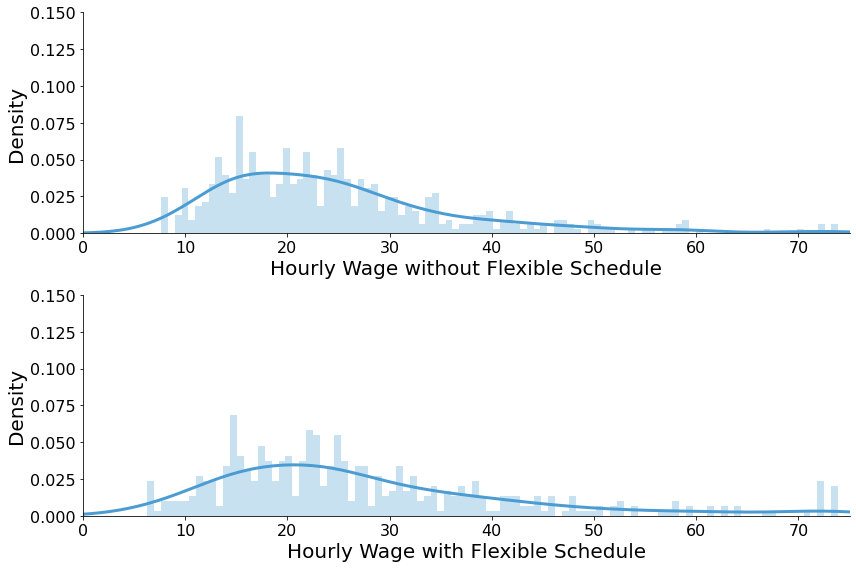

In [43]:
binary_wage_distr(men, 'flexsched', 'wage_flexsched', 'employed', 'Schedule', 'men_wage_flexsched_hs.png')


/Users/megan.mccoy/anaconda3/envs/atus/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/megan.mccoy/anaconda3/envs/atus/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


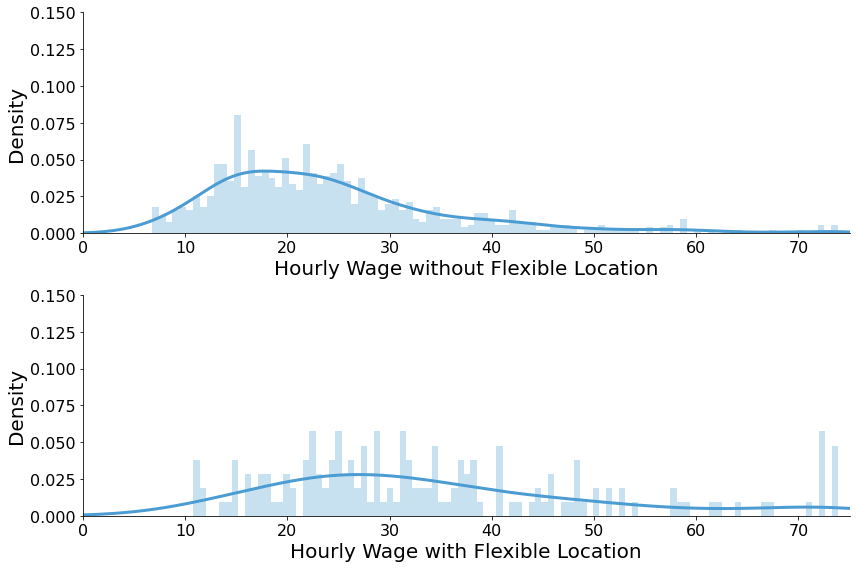

In [44]:
binary_wage_distr(men, 'flexloc', 'wage_flexloc', 'employed', 'Location', 'men_wage_flexloc_hs.png')

/Users/megan.mccoy/anaconda3/envs/atus/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/megan.mccoy/anaconda3/envs/atus/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


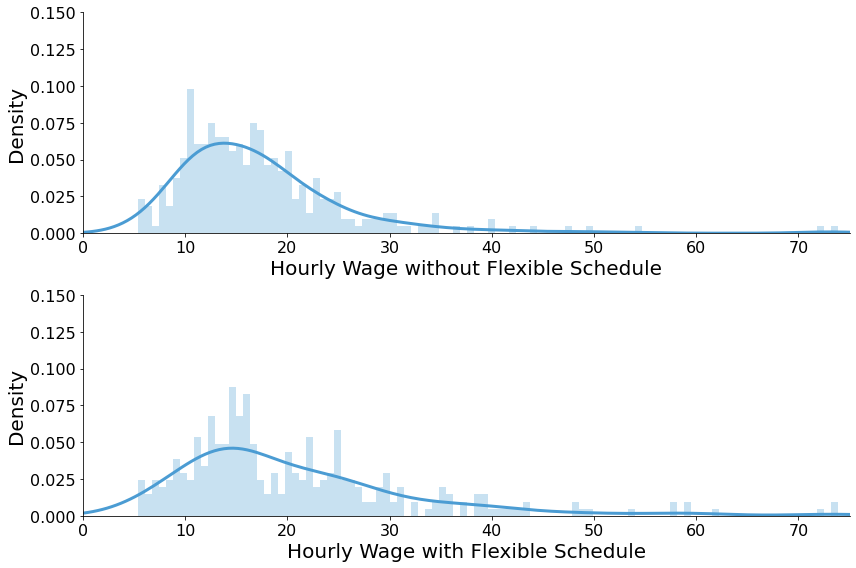

In [45]:
binary_wage_distr(women, 'flexsched', 'wage_flexsched', 'employed', 'Schedule', 'women_wage_flexsched_hs.png')

/Users/megan.mccoy/anaconda3/envs/atus/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/megan.mccoy/anaconda3/envs/atus/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


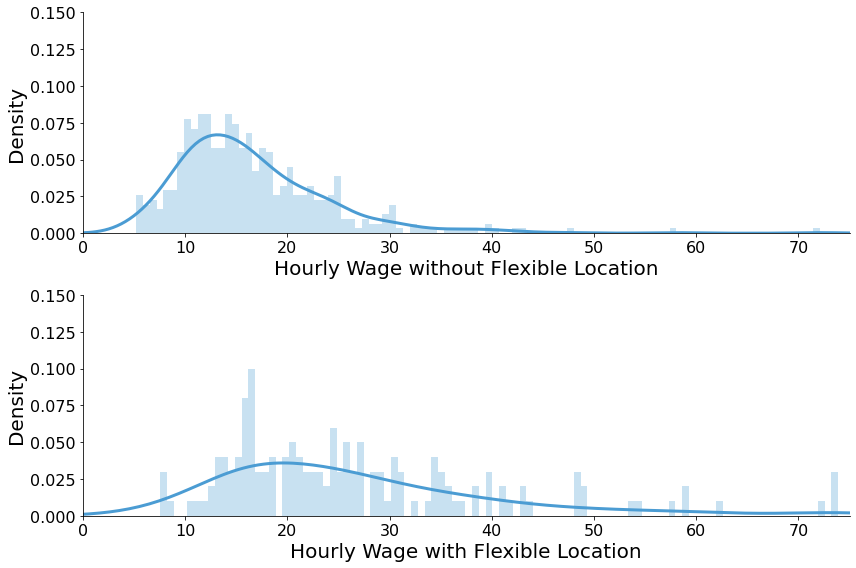

In [46]:
binary_wage_distr(women, 'flexloc', 'wage_flexloc', 'employed', 'Location', 'women_wage_flexloc_hs.png')

# Scratch

#### 1st percentile

In [ ]:
first_pctl = np.zeros(1)

for k in range(2):
    tmp = men[men['flexsched']==k]
    first = np.percentile(tmp['hrwage_r'],1)
    first_pctl = np.append(first_pctl, first)
#     print("5th percentile wage = " + str(first) + " for men with flex level " + str(k))
    
men['wage_flexsched']=men['hrwage_r']

for k in range(2):
    men['wage_flexsched'].iloc[(men['hrwage_r']<first_pctl[k+1]) & (men['flexsched']==k)]=first_pctl[k+1] #k+1 because empty array initiates with zero
        
men['wage_flexsched'].groupby([men['employed'],men['flexsched']]).describe()

In [ ]:
first_pctl = np.zeros(1)

for k in range(2):
    tmp = men[men['flexloc']==k]
    first = np.percentile(tmp['hrwage_r'],1)
    first_pctl = np.append(first_pctl, first)
#     print("5th percentile wage = " + str(first) + " for men with flex level " + str(k))
    
men['wage_flexloc']=men['hrwage_r']

for k in range(2):
    men['wage_flexloc'].iloc[(men['hrwage_r']<first_pctl[k+1]) & (men['flexloc']==k)]=first_pctl[k+1] #k+1 because empty array initiates with zero
        
men['wage_flexloc'].groupby([men['employed'],men['flexloc']]).describe()

#### 5th percentile 

In [ ]:
# fifth_pctl = np.zeros(1)

# for k in range(3):
#     tmp = men[men['flex_sched_score']==k]
#     fifth = np.percentile(tmp['hrwage_r'],5)
#     fifth_pctl = np.append(fifth_pctl, fifth)
# #     print("5th percentile wage = " + str(fifth) + " for men with flex level " + str(k))
    
# men['wage_flexschedscore']=men['hrwage_r']

# for k in range(3):
#     men['wage_flexschedscore'].iloc[(men['hrwage_r']<fifth_pctl[k+1]) & (men['flex_sched_score']==k)]=fifth_pctl[k+1] #k+1 because empty array initiates with zero

# men['wage_flexschedscore'].groupby([men['employed'],men['flex_sched_score']]).describe()

In [ ]:
# fifth_pctl = np.zeros(1)

# for k in range(2):
#     tmp = men[men['flexsched']==k]
#     fifth = np.percentile(tmp['hrwage_r'],5)
#     fifth_pctl = np.append(fifth_pctl, fifth)
# #     print("5th percentile wage = " + str(fifth) + " for men with flex level " + str(k))
    
# men['wage_flexsched']=men['hrwage_r']

# for k in range(2):
#     men['wage_flexsched'].iloc[(men['hrwage_r']<fifth_pctl[k+1]) & (men['flexsched']==k)]=fifth_pctl[k+1] #k+1 because empty array initiates with zero
        
# men['wage_flexsched'].groupby([men['employed'],men['flexsched']]).describe()

In [ ]:
# fifth_pctl = np.zeros(1)

# for k in range(2):
#     tmp = men[men['flexloc']==k]
#     fifth = np.percentile(tmp['hrwage_r'],5)
#     fifth_pctl = np.append(fifth_pctl, fifth)
# #     print("5th percentile wage = " + str(fifth) + " for men with flex level " + str(k))
    
# men['wage_flexloc']=men['hrwage_r']

# for k in range(2):
#     men['wage_flexloc'].iloc[(men['hrwage_r']<fifth_pctl[k+1]) & (men['flexloc']==k)]=fifth_pctl[k+1] #k+1 because empty array initiates with zero
        
# men['wage_flexloc'].groupby([men['employed'],men['flexloc']]).describe()

In [ ]:
def binary_wage_distr(data: pd.DataFrame, flex: str, wage: str, employed: str):
    """
    """
    fig, ax = plt.subplots(2, 1, figsize=(12, 8))

    for k in range(2):
        tmp = data[(data[flex]==k) & (data[employed]==1)]
        sns.kdeplot(tmp[wage], color='#4B9CD3', ax=ax[k], fill=True)#, kde=True) #hist_kws={'alpha' : .3}, bins=100, 
#         ax[k].set_ylim([0,0.1])
#         ax[k].set_xlim([0,75])
        if k == 1:
            ax[k].set(xlabel = 'Hourly Wage with Flexible Schedule')
        elif k == 0:
            ax[k].set(xlabel = 'Hourly Wage without Flexible Schedule')
        else:
            print("Not binary k")

    plt.tight_layout()


In [ ]:
def bootstrap_est(data: pd.DataFrame, flex: str, wage: str, dur: str, n_samples:int, ):
    """
    
    * Very slow: 36.6 s ± 8.07 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
    """
    
    bootstrapped_data = bootstrap(data, n_samples)   
    
    # Gamma

    print("Gamma Estimation\n") 
    
    logL_gamma = []
    lambdas_gamma = []
    etas_gamma = []
    mus_gamma = []
    sigmas_gamma = []
    gammas = []

    for sample in bootstrapped_data:
        est_g = est_gamma(sample, flex, wage, dur)

        logL_gamma.append(est_g[0])

        estimated = est_g[1]

        lambdas_gamma.append(estimated[0])
        etas_gamma.append(estimated[1])
        gammas.append(estimated[2])
        mus_gamma.append(estimated[3])
        sigmas_gamma.append(estimated[4])  
        
    gamma_estimates = [logL_gamma, lambdas_gamma, etas_gamma, mus_gamma, sigmas_gamma, gammas]
    
    gamma_stats = []
    for i in gamma_estimates:
        gamma_stats.append(fit_stats(i))
    
    # Zeta
    
    print("\nZeta Estimation\n")
    
    logL_zetas = []
    lambdas_zetas = []
    etas_zetas = []
    mus_zetas = []
    sigmas_zetas = []
    zetas = []

    for sample in bootstrapped_data:
        est_z = est_zeta(sample, flex, wage, dur)

        logL_zetas.append(est_z[0])

        tmp = est_z[1]

        lambdas_zetas.append(tmp[0])
        etas_zetas.append(tmp[1])
        zetas.append(tmp[2])
        mus_zetas.append(tmp[3])
        sigmas_zetas.append(tmp[4])
        
    zeta_estimates = [logL_zetas, lambdas_zetas, etas_zetas, mus_zetas, sigmas_zetas, zetas]
    
    zeta_stats = []
    for i in zeta_estimates:
        zeta_stats.append(fit_stats(i))

#     return print("Gamma stats: ", gamma_stats,
#                 "\nZeta stats: ", zeta_stats)

#### 1st percentile

In [ ]:
first_pctl = np.zeros(1)

for k in range(2):
    tmp = women[women['flexsched']==k]
    first = np.percentile(tmp['hrwage_r'],1)
    first_pctl = np.append(first_pctl, first)
#     print("5th percentile wage = " + str(first) + " for women with flex level " + str(k))
    
women['wage_flexsched']=women['hrwage_r']

for k in range(2):
    women['wage_flexsched'].iloc[(women['hrwage_r']<first_pctl[k+1]) & (women['flexsched']==k)]=first_pctl[k+1] #k+1 because empty array initiates with zero

women[['wage_flexsched','hrwage_r']].groupby([women['employed'],women['flexsched']]).describe()        

In [ ]:
first_pctl = np.zeros(1)

for k in range(2):
    tmp = women[women['flexloc']==k]
    first = np.percentile(tmp['hrwage_r'],1)
    first_pctl = np.append(first_pctl, first)
#     print("5th percentile wage = " + str(first) + " for women with flex level " + str(k))
    
women['wage_flexloc']=women['hrwage_r']

for k in range(2):
    women['wage_flexloc'].iloc[(women['hrwage_r']<first_pctl[k+1]) & (women['flexloc']==k)]=first_pctl[k+1] #k+1 because empty array initiates with zero

women[['wage_flexloc','hrwage_r']].groupby([women['employed'],women['flexloc']]).describe()        

#### 5th percentile

In [ ]:
# fifth_pctl = np.zeros(1)

# for k in range(3):
#     tmp = women[women['flex_sched_score']==k]
#     fifth = np.percentile(tmp['hrwage_r'],5)
#     fifth_pctl = np.append(fifth_pctl, fifth)
# #     print("5th percentile wage = " + str(fifth) + " for women with flex level " + str(k))
    
# women['wage_flexschedscore']=women['hrwage_r']

# for k in range(3):
#     women['wage_flexschedscore'].iloc[(women['hrwage_r']<fifth_pctl[k+1]) & (women['flex_sched_score']==k)]=fifth_pctl[k+1] #k+1 because empty array initiates with zero

# women[['wage_flexschedscore','hrwage_r']].groupby([women['employed'],women['flex_sched_score']]).describe()    

In [ ]:
# fifth_pctl = np.zeros(1)

# for k in range(2):
#     tmp = women[women['flexsched']==k]
#     fifth = np.percentile(tmp['hrwage_r'],5)
#     fifth_pctl = np.append(fifth_pctl, fifth)
# #     print("5th percentile wage = " + str(fifth) + " for women with flex level " + str(k))
    
# women['wage_flexsched']=women['hrwage_r']

# for k in range(2):
#     women['wage_flexsched'].iloc[(women['hrwage_r']<fifth_pctl[k+1]) & (women['flexsched']==k)]=fifth_pctl[k+1] #k+1 because empty array initiates with zero

# women[['wage_flexsched','hrwage_r']].groupby([women['employed'],women['flexsched']]).describe()        

In [ ]:
# fifth_pctl = np.zeros(1)

# for k in range(2):
#     tmp = women[women['flexloc']==k]
#     fifth = np.percentile(tmp['hrwage_r'],5)
#     fifth_pctl = np.append(fifth_pctl, fifth)
#     print("5th percentile wage = " + str(fifth) + " for women with flex level " + str(k))
    
# women['wage_flexloc']=women['hrwage_r']

# for k in range(2):
#     women['wage_flexloc'].iloc[(women['hrwage_r']<fifth_pctl[k+1]) & (women['flexloc']==k)]=fifth_pctl[k+1] #k+1 because empty array initiates with zero

# women[['wage_flexloc','hrwage_r']].groupby([women['employed'],women['flexloc']]).describe()        

## Before functionalizing

In [ ]:
# Estimate ζ, holding γ constant and cost = 0
params = np.array([λ, η, ζ, men['wage_flexsched'].mean(), men['wage_flexsched'].std()])

logL_opt = lambda x: log_L(men, 'flexsched', 'wage_flexsched', 'dur', 
                            np.array([0,0]), α, x[0], x[1], x[2], γ,
                            x[3], x[4])

est_zeta = minimize(logL_opt, params, method='Nelder-Mead', options={'maxiter':1000, 'disp':True}, bounds=Bounds)
est_zeta.x


In [ ]:
# Estimate c, holding γ and ζ constant 
params = np.array([λ, η, c_k[1], men['wage_flexsched'].mean(), men['wage_flexsched'].std()])

logL_opt = lambda x: log_L(men, 'flexsched', 'wage_flexsched', 'dur', men['wage_flexsched'].min(), 
                            np.array([0,x[0]]), prob_k, α, x[1], x[2], est_zeta.x[2], est_gamma.x[2],
                            x[3], x[4])

est_c = minimize(logL_opt, params, method='Nelder-Mead', options={'maxiter':1000, 'disp':True}, bounds=Bounds)
est_c.x


In [ ]:
## Estimate γ, holding ζ constant and cost = 0
# params = np.array([λ, η, γ, men['wage_flexsched'].mean(), men['wage_flexsched'].std()])

# Bootstrapping
bootstrapped_data = bootstrap(men, n_samples=30)

logL_gamma = []
lambdas_gamma = []
etas_gamma = []
mus_gamma = []
sigmas_gamma = []
gammas = []

for sample in bootstrapped_data:
    params = np.array([λ, η, γ, sample['wage_flexsched'].mean(), sample['wage_flexsched'].std()])
    
    logL_opt = lambda x: log_L(sample, 'flexsched', 'wage_flexsched', 'dur', sample['wage_flexsched'].min(), 
                            np.array([0,0]), prob_k, α, x[0], x[1], ζ, x[2],
                            x[3], x[4])

    est = minimize(logL_opt, params, method='Nelder-Mead', options={'maxiter':1000}, bounds=Bounds)
    
    logL_gamma.append(est.fun)
    lambdas_gamma.append(est.x[0])
    etas_gamma.append(est.x[1])
    gammas.append(est.x[2])
    mus_gamma.append(est.x[3])
    sigmas_gamma.append(est.x[4])

In [ ]:
# Estimate ζ, holding γ constant and cost = 0
# params = np.array([λ, η, ζ, men['wage_flexsched'].mean(), men['wage_flexsched'].std()])

## Bootstrapping
bootstrapped_data = bootstrap(men, n_samples=30)

logL_zetas = []
lambdas_zetas = []
etas_zetas = []
mus_zetas = []
sigmas_zetas = []
zetas = []

for sample in bootstrapped_data:
    params = np.array([λ, η, ζ, sample['wage_flexsched'].mean(), sample['wage_flexsched'].std()])

    logL_opt = lambda x: log_L(sample, 'flexsched', 'wage_flexsched', 'dur', sample['wage_flexsched'].min(), 
                            np.array([0,0]), prob_k, α, x[0], x[1], x[2], γ,
                            x[3], x[4])

    est = minimize(logL_opt, params, method='Nelder-Mead', options={'maxiter':1000}, bounds=Bounds)
    
    logL_zetas.append(est.fun)
    lambdas_zetas.append(est.x[0])
    etas_zetas.append(est.x[1])
    zetas.append(est.x[2])
    mus_zetas.append(est.x[3])
    sigmas_zetas.append(est.x[4])


#### Compare Bootstrapped Results

In [ ]:
mylist = [logL_gamma, lambdas_gamma, etas_gamma, mus_gamma, sigmas_gamma, gammas]

for i in mylist:
    fit_stats(i)

In [ ]:
mylist = [logL_zetas, lambdas_zetas, etas_zetas, mus_zetas, sigmas_zetas, zetas]

for i in mylist:
    fit_stats(i)

### Estimation: Men, Binary Location Flex

In [ ]:
# Estimation Specific Parameters

γ = 0.625 # Relative value of location flexibility to high salary from He et al (2021)

prob_k = np.array([0.584541, 0.415459])

In [ ]:
men['flexloc'].value_counts(normalize=True, sort=False)

In [ ]:
# Estimate γ, holding ζ constant cost = 0
params = np.array([λ, η, γ, men['wage_flexloc'].mean(), men['wage_flexloc'].std()])

logL_opt = lambda x: log_L(men, 'flexloc', 'wage_flexloc', 'dur', men['wage_flexloc'].min(), 
                            np.array([0,0]), prob_k, α, x[0], x[1], ζ, x[2],
                            x[3], x[4])

est = minimize(logL_opt, params, method='Nelder-Mead', options={'maxiter':1000, 'disp':True}, bounds=Bounds)
est.x


In [ ]:
# Estimate ζ, holding γ constant and cost = 0
params = np.array([λ, η, ζ, men['wage_flexloc'].mean(), men['wage_flexloc'].std()])

logL_opt = lambda x: log_L(men, 'flexloc', 'wage_flexloc', 'dur', men['wage_flexloc'].min(), 
                            np.array([0,0]), prob_k, α, x[0], x[1], x[2], γ,
                            x[3], x[4])

est = minimize(logL_opt, params, method='Nelder-Mead', options={'maxiter':1000, 'disp':True}, bounds=Bounds)
est.x


#### Bootstrapping

In [ ]:
## Estimate γ, holding ζ constant and cost = 0
bootstrapped_data = bootstrap(men, n_samples=30)

logL_gamma = []
lambdas_gamma = []
etas_gamma = []
mus_gamma = []
sigmas_gamma = []
gammas = []

for sample in bootstrapped_data:
    params = np.array([λ, η, γ, sample['wage_flexloc'].mean(), sample['wage_flexloc'].std()])
    
    logL_opt = lambda x: log_L(sample, 'flexloc', 'wage_flexloc', 'dur', sample['wage_flexloc'].min(), 
                            np.array([0,0]), prob_k, α, x[0], x[1], ζ, x[2],
                            x[3], x[4])

    est = minimize(logL_opt, params, method='Nelder-Mead', options={'maxiter':1000}, bounds=Bounds)
    
    logL_gamma.append(est.fun)
    lambdas_gamma.append(est.x[0])
    etas_gamma.append(est.x[1])
    gammas.append(est.x[2])
    mus_gamma.append(est.x[3])
    sigmas_gamma.append(est.x[4])

In [ ]:
# Estimate ζ, holding γ constant and cost = 0
bootstrapped_data = bootstrap(men, n_samples=30)

logL_zetas = []
lambdas_zetas = []
etas_zetas = []
mus_zetas = []
sigmas_zetas = []
zetas = []

for sample in bootstrapped_data:
    params = np.array([λ, η, ζ, sample['wage_flexloc'].mean(), sample['wage_flexloc'].std()])

    logL_opt = lambda x: log_L(sample, 'flexloc', 'wage_flexloc', 'dur', sample['wage_flexloc'].min(), 
                            np.array([0,0]), prob_k, α, x[0], x[1], x[2], γ,
                            x[3], x[4])

    est = minimize(logL_opt, params, method='Nelder-Mead', options={'maxiter':1000}, bounds=Bounds)
    
    logL_zetas.append(est.fun)
    lambdas_zetas.append(est.x[0])
    etas_zetas.append(est.x[1])
    zetas.append(est.x[2])
    mus_zetas.append(est.x[3])
    sigmas_zetas.append(est.x[4])


#### Compare Bootstrapped Results

In [ ]:
mylist = [logL_gamma, lambdas_gamma, etas_gamma, mus_gamma, sigmas_gamma, gammas]

for i in mylist:
    fit_stats(i)

In [ ]:
mylist = [logL_zetas, lambdas_zetas, etas_zetas, mus_zetas, sigmas_zetas, zetas]

for i in mylist:
    fit_stats(i)

In [ ]:
fig, ax = plt.subplots(3,2,figsize=(8,6))

sns.distplot(lambdas_gamma, ax=ax[0,0]).set(title="Lambda")
sns.distplot(etas_gamma, ax=ax[0,1]).set(title="Eta")
sns.distplot(mus_gamma, ax=ax[1,0]).set(title="Mu")
sns.distplot(sigmas_gamma, ax=ax[1,1]).set(title="Sigma")
sns.distplot(gammas, ax=ax[2,0]).set(title="Gammas")
sns.distplot(logL_gamma, ax=ax[2,1]).set(title="Log-Likelihood")

plt.tight_layout()

In [ ]:
fig, ax = plt.subplots(3,2,figsize=(8,6))

sns.distplot(lambdas_zetas, ax=ax[0,0]).set(title="Lambda")
sns.distplot(etas_zetas, ax=ax[0,1]).set(title="Eta")
sns.distplot(mus_zetas, ax=ax[1,0]).set(title="Mu")
sns.distplot(sigmas_zetas, ax=ax[1,1]).set(title="Sigma")
sns.distplot(zetas, ax=ax[2,0]).set(title="Zetas")
sns.distplot(logL_zetas, ax=ax[2,1]).set(title="Log-Likelihood")

plt.tight_layout()

### Estimation: Women, Binary Schedule Flex

In [ ]:
# Estimation Specific Parameters

γ = 0.6875 # Relative value of schedule flexibility to high salary from He et al (2021)

prob_k = np.array([0.40264, 0.59736])

In [ ]:
women['flexsched'].value_counts(normalize=True, sort=False)

In [ ]:
## Estimate γ, holding ζ constant and setting cost = 0
params = np.array([λ, η, γ, women['wage_flexsched'].mean(), women['wage_flexsched'].std()])

logL_opt = lambda x: log_L(women, 'flexsched', 'wage_flexsched', 'dur', women['wage_flexsched'].min(), 
                            np.array([0,0]), prob_k, α, x[0], x[1], 1.28, x[2], 
                            x[3], x[4])

est = minimize(logL_opt, params, method='Nelder-Mead', options={'maxiter':1000, 'disp':True}, bounds=Bounds)
est.x


In [ ]:
## Estimate ζ, holding γ constant and setting cost=0
params = np.array([λ, η, ζ, women['wage_flexsched'].mean(), women['wage_flexsched'].std()])

logL_opt = lambda x: log_L(women, 'flexsched', 'wage_flexsched', 'dur', women['wage_flexsched'].min(), 
                            np.array([0,0]), prob_k, α, x[0], x[1], x[2], -.144,
                            x[3], x[4])

est = minimize(logL_opt, params, method='Nelder-Mead', options={'maxiter':1000, 'disp':True}, bounds=Bounds)
est.x


#### Bootstrapping

In [ ]:
## Estimate γ, holding ζ constant and cost = 0

bootstrapped_data = bootstrap(women, n_samples=30)

logL_gamma = []
lambdas_gamma = []
etas_gamma = []
mus_gamma = []
sigmas_gamma = []
gammas = []

for sample in bootstrapped_data:
    params = np.array([λ, η, γ, sample['wage_flexsched'].mean(), sample['wage_flexsched'].std()])
    
    logL_opt = lambda x: log_L(sample, 'flexsched', 'wage_flexsched', 'dur', sample['wage_flexsched'].min(), 
                            np.array([0,0]), prob_k, α, x[0], x[1], ζ, x[2],
                            x[3], x[4])

    est = minimize(logL_opt, params, method='Nelder-Mead', options={'maxiter':1000}, bounds=Bounds)
    
    logL_gamma.append(est.fun)
    lambdas_gamma.append(est.x[0])
    etas_gamma.append(est.x[1])
    gammas.append(est.x[2])
    mus_gamma.append(est.x[3])
    sigmas_gamma.append(est.x[4])

In [ ]:
# Estimate ζ, holding γ constant and cost = 0
bootstrapped_data = bootstrap(women, n_samples=30)

logL_zetas = []
lambdas_zetas = []
etas_zetas = []
mus_zetas = []
sigmas_zetas = []
zetas = []

for sample in bootstrapped_data:
    params = np.array([λ, η, ζ, sample['wage_flexsched'].mean(), sample['wage_flexsched'].std()])
    
    logL_opt = lambda x: log_L(sample, 'flexsched', 'wage_flexsched', 'dur', sample['wage_flexsched'].min(), 
                            np.array([0,0]), prob_k, α, x[0], x[1], x[2], γ,
                            x[3], x[4])

    est = minimize(logL_opt, params, method='Nelder-Mead', options={'maxiter':1000}, bounds=Bounds)
    
    logL_zetas.append(est.fun)
    lambdas_zetas.append(est.x[0])
    etas_zetas.append(est.x[1])
    zetas.append(est.x[2])
    mus_zetas.append(est.x[3])
    sigmas_zetas.append(est.x[4])


#### Compare Bootstrapped Results

In [ ]:
mylist = [logL_gamma, lambdas_gamma, etas_gamma, mus_gamma, sigmas_gamma, gammas]

for i in mylist:
    fit_stats(i)

In [ ]:
mylist = [logL_zetas, lambdas_zetas, etas_zetas, mus_zetas, sigmas_zetas, zetas]

for i in mylist:
    fit_stats(i)

In [ ]:
fig, ax = plt.subplots(3,2,figsize=(8,6))

sns.distplot(lambdas_gamma, ax=ax[0,0]).set(title="Lambda")
sns.distplot(etas_gamma, ax=ax[0,1]).set(title="Eta")
sns.distplot(mus_gamma, ax=ax[1,0]).set(title="Mu")
sns.distplot(sigmas_gamma, ax=ax[1,1]).set(title="Sigma")
sns.distplot(gammas, ax=ax[2,0]).set(title="Gammas")
sns.distplot(logL_gamma, ax=ax[2,1]).set(title="Log-Likelihood")

plt.tight_layout()

In [ ]:
fig, ax = plt.subplots(3,2,figsize=(8,6))

sns.distplot(lambdas_zetas, ax=ax[0,0]).set(title="Lambda")
sns.distplot(etas_zetas, ax=ax[0,1]).set(title="Eta")
sns.distplot(mus_zetas, ax=ax[1,0]).set(title="Mu")
sns.distplot(sigmas_zetas, ax=ax[1,1]).set(title="Sigma")
sns.distplot(zetas, ax=ax[2,0]).set(title="Zetas")
sns.distplot(logL_zetas, ax=ax[2,1]).set(title="Log-Likelihood")

plt.tight_layout()

### Estimation: Women, Binary Location Flex

In [ ]:
women['flexloc'].value_counts(normalize=True, sort=False)

In [ ]:
# Utility measure for type of flex

γ = 0.625 # Relative value of location flexibility to high salary from He et al (2021)

prob_k = np.array([0.618812, 0.381188])


In [ ]:
## STRANGEST OUTPUT!

# Estimate γ, holding ζ constant and setting cost = 0
params = np.array([λ, η, γ, women['wage_flexloc'].mean(), women['wage_flexloc'].std()])

logL_opt = lambda x: log_L(women, 'flexloc', 'wage_flexloc', 'dur', women['wage_flexloc'].min(), 
                            np.array([0,0]), prob_k, α, x[0], x[1], ζ, x[2], 
                            x[3], x[4])

est = minimize(logL_opt, params, method='Nelder-Mead', options={'maxiter':1000, 'disp':True}, bounds=Bounds)
est.x

In [ ]:
# Estimate ζ, holding γ constant and setting cost=0
params = np.array([λ, η, ζ, women['wage_flexloc'].mean(), women['wage_flexloc'].std()])

logL_opt = lambda x: log_L(women, 'flexloc', 'wage_flexloc', 'dur', women['wage_flexloc'].min(), 
                            np.array([0,0]), prob_k, α, x[0], x[1], x[2], γ,
                            x[3], x[4])

est = minimize(logL_opt, params, method='Nelder-Mead', options={'maxiter':1000, 'disp':True}, bounds=Bounds)
est.x

#### Bootstrapping

In [ ]:
# Estimate γ, holding ζ constant and cost = 0

bootstrapped_data = bootstrap(women, n_samples=30)

logL_gamma = []
lambdas_gamma = []
etas_gamma = []
mus_gamma = []
sigmas_gamma = []
gammas = []

for sample in bootstrapped_data:
    params = np.array([λ, η, γ, sample['wage_flexloc'].mean(), sample['wage_flexloc'].std()])
    
    logL_opt = lambda x: log_L(sample, 'flexloc', 'wage_flexloc', 'dur', sample['wage_flexloc'].min(), 
                            np.array([0,0]), prob_k, α, x[0], x[1], ζ, x[2],
                            x[3], x[4])

    est = minimize(logL_opt, params, method='Nelder-Mead', options={'maxiter':1000}, bounds=Bounds)
    
    logL_gamma.append(est.fun)
    lambdas_gamma.append(est.x[0])
    etas_gamma.append(est.x[1])
    gammas.append(est.x[2])
    mus_gamma.append(est.x[3])
    sigmas_gamma.append(est.x[4])

In [ ]:
# Estimate ζ, holding γ constant and cost = 0
bootstrapped_data = bootstrap(women, n_samples=30)

logL_zetas = []
lambdas_zetas = []
etas_zetas = []
mus_zetas = []
sigmas_zetas = []
zetas = []

for sample in bootstrapped_data:
    params = np.array([λ, η, ζ, sample['wage_flexloc'].mean(), sample['wage_flexloc'].std()])
    
    logL_opt = lambda x: log_L(sample, 'flexloc', 'wage_flexloc', 'dur', sample['wage_flexloc'].min(), 
                            np.array([0,0]), prob_k, α, x[0], x[1], x[2], γ,
                            x[3], x[4])

    est = minimize(logL_opt, params, method='Nelder-Mead', options={'maxiter':1000}, bounds=Bounds)
    
    logL_zetas.append(est.fun)
    lambdas_zetas.append(est.x[0])
    etas_zetas.append(est.x[1])
    zetas.append(est.x[2])
    mus_zetas.append(est.x[3])
    sigmas_zetas.append(est.x[4])


#### Compare Bootstrapped Results

In [ ]:
mylist = [logL_gamma, lambdas_gamma, etas_gamma, mus_gamma, sigmas_gamma, gammas]

for i in mylist:
    fit_stats(i)

In [ ]:
mylist = [logL_zetas, lambdas_zetas, etas_zetas, mus_zetas, sigmas_zetas, zetas]

for i in mylist:
    fit_stats(i)

In [ ]:
fig, ax = plt.subplots(3,2,figsize=(8,6))

sns.distplot(lambdas_gamma, ax=ax[0,0]).set(title="Lambda")
sns.distplot(etas_gamma, ax=ax[0,1]).set(title="Eta")
sns.distplot(mus_gamma, ax=ax[1,0]).set(title="Mu")
sns.distplot(sigmas_gamma, ax=ax[1,1]).set(title="Sigma")
sns.distplot(gammas, ax=ax[2,0]).set(title="Gammas")
sns.distplot(logL_gamma, ax=ax[2,1]).set(title="Log-Likelihood")

plt.tight_layout()

In [ ]:
fig, ax = plt.subplots(3,2,figsize=(8,6))

sns.distplot(lambdas_zetas, ax=ax[0,0]).set(title="Lambda")
sns.distplot(etas_zetas, ax=ax[0,1]).set(title="Eta")
sns.distplot(mus_zetas, ax=ax[1,0]).set(title="Mu")
sns.distplot(sigmas_zetas, ax=ax[1,1]).set(title="Sigma")
sns.distplot(zetas, ax=ax[2,0]).set(title="Zetas")
sns.distplot(logL_zetas, ax=ax[2,1]).set(title="Log-Likelihood")

plt.tight_layout()

## Utility with wage and flex; Productivity with TFP coeff; Two-Stage Estimation

In [ ]:
# Two-stage estimation

## Labor Market Variables in the first stage
Bounds1 = ((0,999), (0,999), (0,999), (0,999))

params1 = np.array([λ, η, men['wage_flexsched'].mean(), men['wage_flexsched'].std()])

logL_opt1 = lambda x: log_L(men, 'flex', 'wage_flexsched', 'dur', men['wage_flexsched'].min(), 
                            np.array([0,7]), prob_k, α, x[0], x[1], ζ, γ,
                            x[2], x[3])

est2 = minimize(logL_opt1, params1, method='Nelder-Mead', options={'maxiter':500, 'disp':True}, bounds=Bounds1)

## Flexibility Variables in the second stage
params2 = np.array([c_k[1], ζ, γ])

logL_opt2 = lambda x: log_L(men, 'flex', 'wage_flexsched', 'dur', men['wage_flexsched'].min(), 
                            np.array([0,x[0]]), prob_k, α, est2.x[0], est2.x[1], x[1], x[2],
                            est2.x[2], est2.x[3])

est2_second = minimize(logL_opt2, params2, method='Nelder-Mead', options={'maxiter':500, 'disp':True})

In [ ]:
print("Men's Labor market variables [λ, η, μ, σ] = "+ str(est2.x))
print("Men's Flexibility variables [c(1), ζ, γ] = "+ str(est2_second.x))

In [ ]:
# Two-stage estimation with bootstrapping

## Labor Market Variables in the first stage: λ, η, μ, σ
Bounds1 = ((0,999), (0,999), (0,999), (0,999))
params1 = np.array([λ, η, men['wage_flexsched'].mean(), men['wage_flexsched'].std()])

## Flexibility Variables in the second stage: c(k), ζ, γ
params2 = np.array([c_k[1], ζ, γ])

## Bootstrapping
bootstrapped_data = bootstrap(men, n_samples=30)

logL1 = []
logL2 = []
lambdas = []
etas = []
mus = []
sigmas = []
cs = []
zetas = []
gammas = []

for sample in bootstrapped_data:
    logL_opt1 = lambda x: log_L(sample, 'flex', 'wage_flexsched', 'dur', sample['wage_flexsched'].min(), 
                            np.array([0,7]), prob_k, α, x[0], x[1], ζ, γ,
                            x[2], x[3])
    est2 = minimize(logL_opt1, params1, method='Nelder-Mead', bounds=Bounds1)#options={'maxiter':500, 'disp':True}, 
    
    logL_opt2 = lambda x: log_L(sample, 'flex', 'wage_flexsched', 'dur', sample['wage_flexsched'].min(), 
                            np.array([0,x[0]]), prob_k, α, est2.x[0], est2.x[1], x[1], x[2],
                            est2.x[2], est2.x[3])
    est2_second = minimize(logL_opt2, params2, method='Nelder-Mead')#, options={'maxiter':500, 'disp':True}
    
    logL1.append(est2.fun)
    logL2.append(est2_second.fun)
    lambdas.append(est2.x[0])
    etas.append(est2.x[1])
    mus.append(est2.x[2])
    sigmas.append(est2.x[3])
    cs.append(est2_second.x[0])
    zetas.append(est2_second.x[1])
    gammas.append(est2_second.x[2])

mylist = [logL1, logL2, lambdas, etas, mus, sigmas, cs, zetas, gammas]

for i in mylist:
    fit_stats(i)

In [ ]:
fig, ax = plt.subplots(3,3,figsize=(12,12))
sns.distplot(logL1, ax=ax[0,0]).set(title="Log-Likelihood of First Stage")
sns.distplot(logL2, ax=ax[0,1]).set(title="Log-Likelihood of Second Stage")
sns.distplot(lambdas, ax=ax[0,2]).set(title="Lambda")
sns.distplot(etas, ax=ax[1,0]).set(title="Eta")
sns.distplot(mus, ax=ax[1,1]).set(title="Mu")
sns.distplot(sigmas, ax=ax[1,2]).set(title="Sigma")
sns.distplot(cs, ax=ax[2,0]).set(title="Cost of Flexibility")
sns.distplot(zetas, ax=ax[2,1]).set(title="Zetas")
sns.distplot(gammas, ax=ax[2,2]).set(title="Gammas")

plt.tight_layout()

In [ ]:
# Binary flexibility

Bounds = ((0,999), (0,999), (0,999), (0,999))

params = np.array([λ, η, men['wage_flexsched'].mean(), men['wage_flexsched'].std()])

logL_opt = lambda x: log_L(men, 'flex', 'wage_flexsched', 'dur', men['wage_flexsched'].min(), 
                            np.array([0,10]), prob_k, α, x[0], x[1], ζ, γ,
                            x[2], x[3])

est2 = minimize(logL_opt, params, method='Nelder-Mead', bounds=Bounds, options={'maxiter':5000, 'disp':True})

In [ ]:
est2.x

In [ ]:
params = np.array([c_k[1], ζ, γ])

logL_opt = lambda x: log_L(men, 'flex', 'wage_flexsched', 'dur', men['wage_flexsched'].min(), 
                            np.array([0,x[0]]), prob_k, α, est2.x[0], est2.x[1], x[1], x[2],
                            est2.x[2], est2.x[3])

est2_second = minimize(logL_opt, params, method='Nelder-Mead', options={'maxiter':500, 'disp':True})

In [ ]:
est2_second.x

In [ ]:
# Binary flexibility

Bounds = ((0,999), (0,999), (0,999), (0,999))

params = np.array([λ, η, women['wage_flexsched'].mean(), women['wage_flexsched'].std()])

logL_opt = lambda x: log_L(women, 'flex', 'wage_flexsched', 'dur', women['wage_flexsched'].min(), 
                            np.array([0,7]), prob_k, α, x[0], x[1], ζ, γ,
                            x[2], x[3])

est2 = minimize(logL_opt, params, method='Nelder-Mead', options={'maxiter':500, 'disp':True}, bounds=Bounds)

In [ ]:
est2.x

In [ ]:
params = np.array([c_k[1], ζ, γ])

logL_opt = lambda x: log_L(women, 'flex', 'wage_flexsched', 'dur', women['wage_flexsched'].min(), 
                            np.array([0,x[0]]), prob_k, α, est2.x[0], est2.x[1], x[1], x[2],
                            est2.x[2], est2.x[3])

est2_second = minimize(logL_opt, params, method='Nelder-Mead', options={'maxiter':500, 'disp':True})

In [ ]:
est2_second.x

In [ ]:
# Two-stage estimation

## Labor Market Variables in the first stage
Bounds1 = ((0,999), (0,999), (0,999), (0,999))

params1 = np.array([λ, η, women['wage_flexsched'].mean(), women['wage_flexsched'].std()])

logL_opt1 = lambda x: log_L(women, 'flex', 'wage_flexsched', 'dur', women['wage_flexsched'].min(), 
                            np.array([0,7]), prob_k, α, x[0], x[1], ζ, γ,
                            x[2], x[3])

est2 = minimize(logL_opt1, params1, method='Nelder-Mead', options={'maxiter':500, 'disp':True}, bounds=Bounds1)

## Flexibility Variables in the second stage
params2 = np.array([c_k[1], ζ, γ])

logL_opt2 = lambda x: log_L(women, 'flex', 'wage_flexsched', 'dur', women['wage_flexsched'].min(), 
                            np.array([0,x[0]]), prob_k, α, est2.x[0], est2.x[1], x[1], x[2],
                            est2.x[2], est2.x[3])

est2_second = minimize(logL_opt2, params2, method='Nelder-Mead', options={'maxiter':500, 'disp':True})

In [ ]:
print("Women's Labor market variables [λ, η, μ, σ] = "+ str(est2.x))
print("Women's Flexibility variables [c(1), ζ, γ] = "+ str(est2_second.x))

In [ ]:
params = np.array([c_k[1], c_k[2], λ, η, γ, men['wage_flexschedscore'].mean(), men['wage_flexschedscore'].std()])

logL_opt = lambda x: log_L(men, 'flex_sched_score', 'wage_flexschedscore', 'dur', men['wage_flexschedscore'].min(), 
                            np.array([0,x[0],x[1]]), prob_k, α, x[2], x[3], ζ, x[4],
                            x[5], x[6])

est4 = minimize(logL_opt, params, method='Nelder-Mead', options={'maxiter':800})

Runs if $\zeta = 1$ and $\gamma = 0$, as in the initial model, so it is a problem of using one flexibility marker to estimate 3 flexibility measures

In [ ]:
est4.success

In [ ]:
est4

In [ ]:
est4.fun

In [ ]:
# Parameters to be estimated 

c_k = np.array([0,5,10])
λ = 2.1
η = 2.1
μ = men['hrwage_r'].groupby(men['flex_sched_score']).mean().values
σ = men['hrwage_r'].groupby(men['flex_sched_score']).std().values

In [ ]:
logL_opt = lambda x: log_L(men, 'flex_sched_score', 'hrwage_r', 'dur', Uk, 
                            x[0], prob_k, 0.5, x[1], x[2],
                            x[3], x[4])

In [ ]:
params = np.array([c_k, float(λ), float(η), μ, σ])
params

In [ ]:
params[1]

In [ ]:
log_L(men, 'flex_sched_score', 'hrwage_r', 'dur', Uk, 
                            params[0], prob_k, 0.5, params[1], params[2],
                            params[3], params[4])

In [ ]:
logL_opt(params)

### Estimation: Men, K=3

In [ ]:
men['flex_sched_score'].value_counts(normalize=True, sort=False)

In [ ]:
prob_k = np.array([0.274557, 0.547504, 0.177939])

In [ ]:
# Two-stage estimation

## Labor Market Variables in the first stage
Bounds1 = ((0,999), (0,999), (0,999), (0,999))

params1 = np.array([λ, η, men['wage_flexschedscore'].mean(), men['wage_flexschedscore'].std()])

logL_opt1 = lambda x: log_L(men, 'flex_sched_score', 'wage_flexschedscore', 'dur', men['wage_flexschedscore'].min(), 
                            np.array([0,7,10]), prob_k, α, x[0], x[1], ζ, γ,
                            x[2], x[3])

est4 = minimize(logL_opt1, params1, method='Nelder-Mead', options={'maxiter':500, 'disp':True}, bounds=Bounds1)

## Flexibility Variables in the second stage
params2 = np.array([c_k[1], c_k[2], ζ, γ])

logL_opt2 = lambda x: log_L(men, 'flex_sched_score', 'wage_flexschedscore', 'dur', men['wage_flexschedscore'].min(), 
                            np.array([0,x[0],x[1]]), prob_k, α, est4.x[0], est4.x[1], x[2], x[3],
                            est4.x[2], est4.x[3])

est4_second = minimize(logL_opt2, params2, method='Nelder-Mead', options={'maxiter':500, 'disp':True})

In [ ]:
print("Men's Labor market variables [λ, η, μ, σ] = "+ str(est4.x))
print("Men's Flexibility variables [c(1), c(2), ζ, γ] = "+ str(est4_second.x))

### Estimation: Women, K=3 
Estimation is finding $\mu=0$

In [ ]:
women['flex_sched_score'].value_counts(normalize=True, sort=False)

In [ ]:
prob_k = np.array([0.402640, 0.444719, 0.152640])

In [ ]:
# Two-stage estimation

# Labor Market Variables in the first stage
Bounds1 = ((0,999), (0,999), (0,999), (0,999))

params1 = np.array([λ, η, women['wage_flexschedscore'].mean(), women['wage_flexschedscore'].std()])

logL_opt1 = lambda x: log_L(women, 'flex_sched_score', 'wage_flexschedscore', 'dur', women['wage_flexschedscore'].min(), 
                            np.array([0,7,10]), prob_k, α, x[0], x[1], ζ, γ,
                            x[2], x[3])

est4 = minimize(logL_opt1, params1, method='Nelder-Mead', options={'maxiter':500, 'disp':True}, bounds=Bounds1)

# Flexibility Variables in the second stage
params2 = np.array([c_k[1], c_k[2], ζ, γ])

logL_opt2 = lambda x: log_L(women, 'flex_sched_score', 'wage_flexschedscore', 'dur', women['wage_flexschedscore'].min(), 
                            np.array([0,x[0],x[1]]), prob_k, α, est4.x[0], est4.x[1], x[2], x[3],
                            est4.x[2], est4.x[3])

est4_second = minimize(logL_opt2, params2, method='Nelder-Mead', options={'maxiter':1000, 'disp':True})

In [ ]:
print("Women's Labor market variables [λ, η, μ, σ] = "+ str(est4.x))
print("Women's Flexibility variables [c(1), c(2), ζ, γ] = "+ str(est4_second.x))

### Schedule Flexibility

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

for k in range(2):
    tmp = df[(df['flex']==k) & (df['sex']=='male') & (df['employed']==1)]
    sns.distplot(tmp['hrwage_r'], color='#4B9CD3', hist_kws={'alpha' : .3}, bins=100, ax=ax[k])
#     ax[k].legend(['Flexibility Level ' + str(k)])
    ax[k].set_ylim([0,0.1])
    ax[k].set_xlim([0,75])
    if k == 1:
        ax[k].set(xlabel = 'Hourly Wage for Men with Flexible Schedule')
    elif k == 0:
        ax[k].set(xlabel = 'Hourly Wage for Men without Flexible Schedule')
    else:
        print("Not binary k")

# ax.set(xlabel="Distribution of Men's Hourly Wage (raw)")

plt.tight_layout()

fig.savefig('./hrwage_r_men_2flex.png', bbox_inches='tight', transparent=True)

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

for k in range(2):
    tmp = df[(df['flex']==k) & (df['sex']=='female') & (df['employed']==1)]
    sns.distplot(tmp['hrwage_r'], color='#4B9CD3', hist_kws={'alpha' : .3}, bins=100, ax=ax[k])
#     ax[k].legend(['Flexibility Level ' + str(k)])
    ax[k].set_ylim([0,0.1])
    ax[k].set_xlim([0,75])
    if k == 1:
        ax[k].set(xlabel = 'Hourly Wage for Women with Flexible Schedule')
    elif k == 0:
        ax[k].set(xlabel = 'Hourly Wage for Women without Flexible Schedule')
    else:
        print("Not binary k")

# ax.set(xlabel="Distribution of Men's Hourly Wage (raw)")

plt.tight_layout()

fig.savefig('./hrwage_r_women_2flex.png', bbox_inches='tight', transparent=True)

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

for k in range(2):
    tmp = men[(men['flex']==k) & (men['employed']==1)] #(df['sex']=='male') & 
    sns.distplot(tmp['wage_trunc'], color='#4B9CD3', hist_kws={'alpha' : .3}, bins=100, ax=ax[k])
#     ax[k].legend(['Flexibility Level ' + str(k)])
    ax[k].set_ylim([0,0.1])
    ax[k].set_xlim([0,75])
    if k == 1:
        ax[k].set(xlabel = 'Truncated Hourly Wage for Men with Flexible Schedule')
    elif k == 0:
        ax[k].set(xlabel = 'Truncated Hourly Wage for Men without Flexible Schedule')
    else:
        print("Not binary k")

# ax.set(xlabel="Distribution of Men's Hourly Wage (raw)")

plt.tight_layout()

fig.savefig('./wagetrunc_men_2flex.png', bbox_inches='tight', transparent=True)

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

for k in range(2):
    tmp = women[(women['flex']==k) & (women['employed']==1)] #(df['sex']=='male') & 
    sns.distplot(tmp['wage_flexsched'], color='#4B9CD3', hist_kws={'alpha' : .3}, bins=100, ax=ax[k])
#     ax[k].legend(['Flexibility Level ' + str(k)])
    ax[k].set_ylim([0,0.1])
    ax[k].set_xlim([0,75])
    if k == 1:
        ax[k].set(xlabel = 'Truncated Hourly Wage for Women with Flexible Schedule')
    elif k == 0:
        ax[k].set(xlabel = 'Truncated Hourly Wage for Women without Flexible Schedule')
    else:
        print("Not binary k")

# ax.set(xlabel="Distribution of Men's Hourly Wage (raw)")

plt.tight_layout()

fig.savefig('./wagetrunc_women_2flex.png', bbox_inches='tight', transparent=True)

## Flex Schedule Score (k = 3)

In [ ]:
fig, ax = plt.subplots(3, 1, figsize=(12, 8))

for k in range(3):
    tmp = df[(df['flex_sched_score']==k) & (df['sex']=='male') & (df['employed']==1)]
    sns.distplot(tmp['hrwage_r'], color='#4B9CD3', hist_kws={'alpha' : .3}, bins=100, ax=ax[k])
#     ax[k].legend(['Flexibility Level ' + str(k)])
    ax[k].set_ylim([0,0.1])
    ax[k].set_xlim([0,75])
    ax[k].set(xlabel = 'Hourly Wage for Men with Flexibile Schedule Score ' +str(k))

# ax.set(xlabel="Distribution of Men's Hourly Wage (raw)")

plt.tight_layout()

fig.savefig('./hrwage_r_men_3flex.png', bbox_inches='tight', transparent=True)

In [ ]:
fig, ax = plt.subplots(3, 1, figsize=(12, 8))

for k in range(3):
    tmp = df[(df['flex_sched_score']==k) & (df['sex']=='female') & (df['employed']==1)]
    sns.distplot(tmp['hrwage_r'], color='#4B9CD3', hist_kws={'alpha' : .3}, bins=100, ax=ax[k])
#     ax[k].legend(['Flexibility Level ' + str(k)])
    ax[k].set_ylim([0,0.1])
    ax[k].set_xlim([0,75])
    ax[k].set(xlabel = 'Hourly Wage for Women with Flexibile Schedule Score ' +str(k))

# ax.set(xlabel="Distribution of Men's Hourly Wage (raw)")

plt.tight_layout()

fig.savefig('./hrwage_r_women_3flex.png', bbox_inches='tight', transparent=True)

In [ ]:
fig, ax = plt.subplots(3, 1, figsize=(12, 8))

for k in range(3):
    tmp = women[(women['flex_sched_score']==k) & (women['employed']==1)]
    sns.distplot(tmp['wage_flexschedscore'], color='#4B9CD3', hist_kws={'alpha' : .3}, bins=100, ax=ax[k])
#     ax[k].legend(['Flex Level ' + str(k)])
    ax[k].set_ylim([0,0.1])
    ax[k].set_xlim([0,75])
    ax[k].set(xlabel = 'Truncated Hourly Wage for Women with Flexibile Schedule Score ' +str(k))

#ax.set(xlabel="Distribution of Men's Hourly Wage")

plt.tight_layout()

fig.savefig('./wageTrunc_women_3flex.png', bbox_inches='tight', transparent=True)

## Utility Linear in wage and Productivity assumption $y(x;k) = kx$

### Functions

In [ ]:
def Pr_wage_given_match(data: pd.DataFrame, flex: str, wage: str, res_wage: float, c_k: np.array, α: float, μ: float, σ: float):
    """
    Calculates probability of a wage draw conditional on a match being formed 
    
    Inputs
    - data: DataFrame
    - flex: string for name of flexibility column
    - wage: string for name of wage column
    - res_wage: float of observed minimum wage
    - c_k: Kx1 array of cost of providing flexibility
    - α: bargaining parameter
    - μ: location parameter of the log-normal wage distribution
    - σ: scale parameter of the log-normal wage distribution
    
    Functions
    - lognormpdf(x: np.array, μ: float, σ: float)
    - lognormsf(x: np.array, μ: float, σ: float)
    """
    employed_indiv = np.zeros(1) #sets first entry to zero 

    for k in range(len(c_k)):
        tmp = data[data[flex]==k]
        g = ( 1/( α*(k+1) ) ) * lognormpdf( ( 1/( α*(k+1) ) )*( tmp[wage] - (1-α)*res_wage + α*c_k[k] ), μ, σ )
        G_tilde = lognormsf( ( 1/(k+1) )*( res_wage + c_k[k] ), μ, σ )
        divide_thing = g/G_tilde
        employed_indiv = np.append(employed_indiv, divide_thing)
    
    return employed_indiv[1:] #removes first entry 

In [ ]:
def hazard(res_wage: float, c_k: np.array, p_k: np.array, λ: float, μ: float, σ: float):
    """
    Calculates the hazard rate out of employment 
    
    Inputs
    - res_wage: float of observed minimum wage
    - c_k: Kx1 array of cost of providing flexibility
    - p_k: Kx1 array of probability of each level of flexibility
    - λ: arrival rate of offer
    - μ: location parameter of the log-normal wage distribution
    - σ: scale parameter of the log-normal wage distribution
    
    Functions
    - lognormsf(x: np.array, μ: float, σ: float)
    """
    
    prob_sum = 0
    
    if len(p_k)!=len(c_k):
        return print("Length of p_k and c_k do not match.")
    else:
        for k in range(len(c_k)):
            prob_sum += p_k[k] * lognormsf( ( 1/(k+1) )*( res_wage + c_k[k]), μ, σ ) #k+1 because Python index 0

    return λ*prob_sum

In [ ]:
def log_L(data: pd.DataFrame, flex: str, wage: str, dur: str, res_wage: float, c_k: np.array, p_k: np.array, α: float, λ: float, η: float, μ: float, σ: float):
    """
    
    Inputs
    - data: DataFrame of all individuals
    - flex: string for column of flexibility index (k)
    - wage: string for column of wage data 
    - dur: string for unemployment duration data
    - res_wage: float of observed minimum wage
    - c_k: Kx1 array of cost of providing flexibility
    - p_k: Kx1 array of probability of each level of flexibility
    - α: bargaining parameter
    - λ: arrival rate of offer
    - η: termination rate
    - μ: location parameter of the log-normal wage distribution
    - σ: scale parameter of the log-normal wage distribution
    
    Functions
    - hazard(res_wage: np.array, c_k: np.array, p_k: np.array, λ: float, μ: float, σ: float)
    - Pr_wage_given_match(data: pd.DataFrame, flex: str, wage: str, res_wage: np.array, c_k: np.array,  α: float, μ: float, σ: float)
    """
    
    N_log_h = data.count() * np.log( hazard(res_wage, c_k, p_k, λ, μ, σ) )
    N_log_h_plus_η = data.count() * np.log( hazard(res_wage, c_k, p_k, λ, μ, σ) + η )
    
    empl_data = np.sum( np.log( Pr_wage_given_match(data, flex, wage, res_wage, c_k, α, μ, σ) ) )
    
    Nu_log_η = data[dur].count() * np.log(η)
    
    unempl_data = hazard(res_wage, c_k, p_k, λ, μ, σ) * np.sum(data[dur])
    
    logL = -(N_log_h - N_log_h_plus_η + empl_data + Nu_log_η - unempl_data)
    
    return logL[0]

In [ ]:
# Parameters to be estimated 

c_k = np.array([0,5,10])
λ = 10
η = 10

### Estimation: Men, K=3

In [ ]:
men['flex_sched_score'].value_counts(normalize=True, sort=False)

In [ ]:
prob_k = np.array([0.274557, 0.547504, 0.177939])

In [ ]:
params = np.array([c_k[1], c_k[2], λ, η, men['wage_flexschedscore'].mean(), men['wage_flexschedscore'].std()])

logL_opt = lambda x: log_L(men, 'flex_sched_score', 'wage_flexschedscore', 'dur', men['wage_flexschedscore'].min(), 
                            np.array([0,x[0],x[1]]), prob_k, 0.5, x[2], x[3],
                            x[4], x[5])

est4 = minimize(logL_opt, params, method='Nelder-Mead')

In [ ]:
est4.success

In [ ]:
est4.x

In [ ]:
est4.fun

In [ ]:
params = np.array([c_k[1], c_k[2], λ, η, men['hrwage_r'].mean(), men['hrwage_r'].std()])

logL_opt = lambda x: log_L(men, 'flex_sched_score', 'hrwage_r', 'dur', men['hrwage_r'].min(), 
                            np.array([0,x[0],x[1]]), prob_k, 0.5, x[2], x[3],
                            x[4], x[5])

est3 = minimize(logL_opt, params, method='Nelder-Mead')

In [ ]:
est3.success

In [ ]:
est3.x

In [ ]:
est3.fun

### Estimation: Men, K=2

In [ ]:
men['flex'].value_counts(normalize=True, sort=False)

In [ ]:
prob_k = np.array([0.274557, 0.725443])

In [ ]:
params = np.array([c_k[1], λ, η, men['wage_flexsched'].mean(), men['wage_flexsched'].std()])

logL_opt = lambda x: log_L(men, 'flex', 'wage_flexsched', 'dur', men['wage_flexsched'].min(), 
                            np.array([0,x[0]]), prob_k, 0.5, x[1], x[2],
                            x[3],x[4])

est2 = minimize(logL_opt, params, method='Nelder-Mead', options={'maxiter':8000})

In [ ]:
est2.success

In [ ]:
est2.x

In [ ]:
est2.fun

In [ ]:
params = np.array([c_k[1], λ, η, men['hrwage_r'].mean(), men['hrwage_r'].std()])

logL_opt = lambda x: log_L(men, 'flex', 'hrwage_r', 'dur', men['hrwage_r'].min(), 
                            np.array([0,x[0]]), prob_k, 0.5, x[1], x[2],
                            x[3],x[4])

est1 = minimize(logL_opt, params, method='Nelder-Mead', options={'maxiter':8000})

In [ ]:
est1.success

In [ ]:
est1.x

In [ ]:
est1.fun

### Estimation: Women, K=3

In [ ]:
women['flex_sched_score'].value_counts(normalize=True, sort=False)

In [ ]:
prob_k = np.array([0.402640, 0.444719, 0.152640])

In [ ]:
params = np.array([c_k[1], c_k[2], λ, η, women['wage_flexschedscore'].mean(), women['wage_flexschedscore'].std()])

logL_opt = lambda x: log_L(women, 'flex_sched_score', 'wage_flexschedscore', 'dur', women['wage_flexschedscore'].min(), 
                            np.array([0,x[0],x[1]]), prob_k, 0.5, x[2], x[3],
                            x[4], x[5])

est4 = minimize(logL_opt, params, method='Nelder-Mead', options={'maxiter':8000})

c_1 = 5, c_2 = 10

In [ ]:
est4.success

In [ ]:
est4.x

In [ ]:
est4.fun

In [ ]:
# Changes every time I run it for some reason.

params = np.array([c_k[1], c_k[2], λ, η, women['hrwage_r'].mean(), women['hrwage_r'].std()])

logL_opt = lambda x: log_L(women, 'flex_sched_score', 'hrwage_r', 'dur', women['hrwage_r'].min(), 
                            np.array([0,x[0],x[1]]), prob_k, 0.5, x[2], x[3],
                            x[4], x[5])

est3 = minimize(logL_opt, params, method='Nelder-Mead', options={'maxiter':8000})

In [ ]:
est3.success

In [ ]:
est3.x

In [ ]:
est3.fun

### Estimation: Women, K=2

In [ ]:
women['flex'].value_counts(normalize=True, sort=False)

In [ ]:
prob_k = np.array([0.40264, 0.59736])

In [ ]:
# Also changes every time I run it

params = np.array([c_k[1], λ, η, women['wage_flexsched'].mean(), women['wage_flexsched'].std()])

logL_opt = lambda x: log_L(women, 'flex', 'wage_flexsched', 'dur', women['wage_flexsched'].min(), 
                            np.array([0,x[0]]), prob_k, 0.5, x[1], x[2],
                            x[3],x[4])

est2 = minimize(logL_opt, params, method='Nelder-Mead', options={'maxiter':8000})

In [ ]:
est2.success

In [ ]:
est2.x

In [ ]:
est2.fun

In [ ]:
# Consistent across runs

params = np.array([c_k[1], λ, η, women['hrwage_r'].mean(), women['hrwage_r'].std()])

logL_opt = lambda x: log_L(women, 'flex', 'hrwage_r', 'dur', women['hrwage_r'].min(), 
                            np.array([0,x[0]]), prob_k, 0.5, x[1], x[2],
                            x[3],x[4])

est1 = minimize(logL_opt, params, method='Nelder-Mead', options={'maxiter':8000})

In [ ]:
est1.success

In [ ]:
est1.x

In [ ]:
est1.fun

## Pr_wage_match, hazard, and logL with res_wage, mu, and sigma varying with k

In [ ]:
def Pr_wage_given_match(data: pd.DataFrame, flex: str, wage: str, res_wage: float, c_k: np.array, α: float, μ: float, σ: float):
# def Pr_wage_given_match(data: pd.DataFrame, flex: str, wage: str, res_wage: np.array, c_k: np.array, α: float, μ: np.array, σ: np.array):
    """
    Calculates probability of a wage draw conditional on a match being formed 
    
    Inputs
    - data: DataFrame
    - flex: string for name of flexibility column
    - wage: string for name of wage column
    - res_wage: Kx1 array of observed minimum wages for each flexibility level
    - c_k: Kx1 array of cost of providing flexibility
    - α: bargaining parameter
    - μ: array of location parameter of the log-normal wage distribution for each flexibility level
    - σ: array of scale parameter of the log-normal wage distribution for each flexibility level
    
    Functions
    - lognormpdf(x: np.array, μ: float, σ: float)
    - lognormsf(x: np.array, μ: float, σ: float)
    """
    employed_indiv = np.zeros(1) #sets first entry to zero 
# With U, μ and σ constant in flex level k
    for k in range(len(c_k)):
        tmp = data[data[flex]==k]
        g = ( 1/( α*(k+1) ) ) * lognormpdf( ( 1/( α*(k+1) ) )*( tmp[wage] - (1-α)*res_wage + α*c_k[k] ), μ, σ )
        G_tilde = lognormsf( ( 1/(k+1) )*( res_wage + c_k[k] ), μ, σ )
        divide_thing = g/G_tilde
        employed_indiv = np.append(employed_indiv, divide_thing)
# # With U, μ and σ varying with flex level k - unidentified    
#     for k in range(len(res_wage)):
#         tmp = data[data[flex]==k]
#         g = ( 1/( α*(k+1) ) ) * lognormpdf( ( 1/( α*(k+1) ) )*( tmp[wage] - (1-α)*res_wage[k] + α*c_k[k] ), μ[k], σ[k] )
#         G_tilde = lognormsf( ( 1/(k+1) )*( res_wage[k] + c_k[k] ), μ[k], σ[k] )
#         divide_thing = g/G_tilde
#         employed_indiv = np.append(employed_indiv, divide_thing)
    
    return employed_indiv[1:] #removes first entry 

In [ ]:
def hazard(res_wage: float, c_k: np.array, p_k: np.array, λ: float, μ: float, σ: float):
# def hazard(res_wage: np.array, c_k: np.array, p_k: np.array, λ: float, μ: np.array, σ: np.array):
    """
    Calculates the hazard rate out of employment 
    
    Inputs
    - res_wage: Kx1 array of observed minimum wages for each flexibility level
    - c_k: Kx1 array of cost of providing flexibility
    - p_k: Kx1 array of probability of each level of flexibility
    - λ: arrival rate of offer
    - μ: array of location parameter of the log-normal wage distribution for each flexibility level
    - σ: array of scale parameter of the log-normal wage distribution for each flexibility level
    
    Functions
    - lognormsf(x: np.array, μ: float, σ: float)
    """
    
    prob_sum = 0
    
#     if len(res_wage)!=len(c_k):
#         return print("Length of res_wage and c_k do not match.")
#     elif len(res_wage)!=len(p_k):
#         return print("Length of res_wage and p_k do not match.")
    if len(p_k)!=len(c_k):
        return print("Length of p_k and c_k do not match.")
    else:
# With U, μ and σ constant in flex level k
        for k in range(len(c_k)):
            prob_sum += p_k[k] * lognormsf( ( 1/(k+1) )*( res_wage + c_k[k]), μ, σ ) #k+1 because Python index 0

# # With U, μ and σ varying with flex level k - unidentified    
#         for k in range(len(res_wage)):
#             prob_sum += p_k[k] * lognormsf( ( 1/(k+1) )*( res_wage[k] + c_k[k]), μ[k], σ[k] ) #k+1 because Python index 0
    
    return λ*prob_sum#[0]

In [ ]:
def log_L(data: pd.DataFrame, flex: str, wage: str, dur: str, res_wage: float, c_k: np.array, p_k: np.array, α: float, λ: float, η: float, μ: float, σ: float):
# def log_L(data: pd.DataFrame, flex: str, wage: str, dur: str, res_wage: np.array, c_k: np.array, p_k: np.array, α: float, λ: float, η: float, μ: np.array, σ: np.array):
    """
    
    Inputs
    - data: DataFrame of all individuals
    - flex: string for column of flexibility index (k)
    - wage: string for column of wage data 
    - dur: string for unemployment duration data
    - res_wage: Kx1 array of observed minimum wages for each flexibility level
    - c_k: Kx1 array of cost of providing flexibility
    - p_k: Kx1 array of probability of each level of flexibility
    - α: bargaining parameter
    - λ: arrival rate of offer
    - η: termination rate
    - μ: array of location parameter of the log-normal wage distribution for each flexibility level
    - σ: array of scale parameter of the log-normal wage distribution for each flexibility level
    
    Functions
    - hazard(res_wage: np.array, c_k: np.array, p_k: np.array, λ: float, μ: float, σ: float)
    - Pr_wage_given_match(data: pd.DataFrame, flex: str, wage: str, res_wage: np.array, c_k: np.array,  α: float, μ: float, σ: float)
    """
    
    N_log_h = data.count() * np.log( hazard(res_wage, c_k, p_k, λ, μ, σ) )
    N_log_h_plus_η = data.count() * np.log( hazard(res_wage, c_k, p_k, λ, μ, σ) + η )
    
    empl_data = np.sum( np.log( Pr_wage_given_match(data, flex, wage, res_wage, c_k, α, μ, σ) ) )
    
    Nu_log_η = data[dur].count() * np.log(η)
    
    unempl_data = hazard(res_wage, c_k, p_k, λ, μ, σ) * np.sum(data[dur])
    
    logL = -(N_log_h - N_log_h_plus_η + empl_data + Nu_log_η - unempl_data)
    
    return logL[0]

## Old Hazard and Log L (did not copy Pr_wage_match in time)

In [ ]:
def hazard(res_wage: np.array, c_k: np.array, p_k: np.array, λ: float, μ: np.array, σ: np.array):
    """
    Calculates the hazard rate out of employment 
    
    Inputs
    - res_wage: Kx1 array of observed minimum wages for each flexibility level
    - c_k: Kx1 array of cost of providing flexibility
    - p_k: Kx1 array of probability of each level of flexibility
    - λ: arrival rate of offer
    - μ: array of location parameter of the log-normal wage distribution for each flexibility level
    - σ: array of scale parameter of the log-normal wage distribution for each flexibility level
    
    Functions
    - lognormsf(x: np.array, μ: float, σ: float)
    """
    
    prob_sum = 0
    
    if len(res_wage)!=len(c_k):
        return print("Length of res_wage and c_k do not match.")
    elif len(res_wage)!=len(p_k):
        return print("Length of res_wage and p_k do not match.")
    elif len(p_k)!=len(c_k):
        return print("Length of p_k and c_k do not match.")
    else:
        for k in range(len(res_wage)):
            prob_sum += p_k[k] * lognormsf( ( 1/(k+1) )*( res_wage[k] + c_k[k]), μ[k], σ[k] ) #k+1 because Python index 0
    
    return λ*prob_sum

In [ ]:
def log_L(wage: np.array, k: np.array, res_wage: np.array, c_k: np.array, p_k: np.array, dur: np.array, α: float, λ: float, η: float, μ: np.array, σ: np.array):
    """
    
    Inputs
    - wage: Ne x 1 array of observed wage data 
    - k: Ne x 1 array of observed flexibility level data
    - res_wage: Kx1 array of observed minimum wages for each flexibility level
    - c_k: Kx1 array of cost of providing flexibility
    - p_k: Kx1 array of probability of each level of flexibility
    - dur: Nu x 1 array of observed unemployment duration data
    - α: bargaining parameter
    - λ: arrival rate of offer
    - η: termination rate
    - μ: array of location parameter of the log-normal wage distribution for each flexibility level
    - σ: array of scale parameter of the log-normal wage distribution for each flexibility level
    
    Functions
    - hazard(res_wage: np.array, c_k: np.array, p_k: np.array, λ: float, μ: float, σ: float)
    - Pr_wage_given_match(wage: np.array, k: np.array, res_wage: np.array, c_k: np.array,  α: float, μ: float, σ: float)
    """
    
    N_log_h = len(wage) * np.log( hazard(res_wage, c_k, p_k, λ, μ, σ) )
    N_log_h_plus_η = len(wage) * np.log( hazard(res_wage, c_k, p_k, λ, μ, σ) + η )
    
    empl_data = np.sum( np.log( Pr_wage_given_match(wage, k, res_wage, c_k,  α, μ, σ) ) )
    
    Nu_log_η = len(dur) * np.log(η)
    
    unempl_data = hazard(res_wage, c_k, p_k, λ, μ, σ) * np.sum(dur)
    
    logL = N_log_h - N_log_h_plus_η + empl_data + Nu_log_η - unempl_data
    
    return logL

In [ ]:
empl_men = men[men['employed']==1]
len(empl_men)

In [ ]:
unempl_men = men[men['employed']==0]
len(unempl_men)

In [ ]:
fig, ax = plt.subplots(3, 1, figsize=(12, 8))

for k in range(3):
    tmp = df[(df['flex_sched_score']==k) & (df['sex']=='female') & (df['employed']==1)]
    sns.distplot(tmp['hrwage_r'], color='#4B9CD3', hist_kws={'alpha' : .3}, bins=100, ax=ax[k])
    ax[k].legend(['Flex Level ' + str(k)])
    ax[k].set_ylim([0,0.1])
    ax[k].set_xlim([0,75])


#ax.set(xlabel="Distribution of Men's Hourly Wage")

plt.tight_layout()

# fig.savefig('./figures/wage_noMin.png', bbox_inches='tight', transparent=True)